# US Participation, Employment to Population, Unemployment, and Unfilled Vacancies to Population Rates
In this notebook I look at:
* The total population of the US that works or is capable of working. It's referred to as the _Population Level_. It is defined as: "_Persons 16 years of age and older residing in the 50 states and the District of Columbia, who are not inmates of institutions (e.g., penal and mental facilities, homes for the aged), and who are not on active duty in the Armed Forces._" In simpler words, it's the set of people who could in theory work.
* Another key concept in this notebook is the _Labor Force Level_ &mdash; it is a subset of the population level comprising only those who work or are actively looking for work. Naturally `Labor Force Level` < `Population Level`
* Finally we arrive at the _Employment Level_ &mdash; it is a subset of the labor force level comprising only those who work. It follows that: `Employment Level` < `Labor Force Level` < `Population Level`.

I then look at the different ratios involving the sizes of the above-mentioned sets:
1. **Participation Rate**: The percentage of the population level comprising those who work or are actively looking for work, i.e. $\frac{\left|\text{Labor Force Level}\right|}{\left|\text{Population Level}\right|}$
2. **Employment Rate** (aka _Employment/Population Ratio_: The percentage of the labor force level comprising those who work, i.e. $\frac{\left|\text{Employment Level}\right|}{\left|\text{Labor Force Level}\right|}$
3. **Unemployment Rate**: The percentage of the labor force level comprising those who are actively looking for work, i.e. $\frac{\left|\text{Labor Force Level}\right| - \left|\text{Employment Level}\right|}{\left|\text{Labor Force Level}\right|}$
4. **Unfilled Vacancies/Population Rate**: The number of unfilled vacancies as percentage of the population level, i.e. $\frac{\left|\text{Unfilled vacancies}\right|}{\left|\text{Population Level}\right|}$
5. **Vacancy Rate** (aka _Unfilled Vacancies/Labor Force Ratio_): The number of unfilled vacancies as percentage of the labor force level, i.e. $\frac{\left|\text{Unfilled vacancies}\right|}{\left|\text{Labor Force Level}\right|}$
    
    ($\left|X\right|$ denotes the size of set X)

and how they've evolved since 1948.


I also construct a [Beveridge Curve](https://en.wikipedia.org/wiki/Beveridge_curve) for the US job market by plotting the unemployment rate against the vacancy rate.

Throughout this notebook all non-percentage numbers are in the thousands of persons.

In [1]:
# Uncomment if running in Google Colaboratory

# Install the latest version of pandaSDMX
# !pip install pandaSDMX -U

In [2]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import pandasdmx as sdmx

from datetime import date

/usr/local/lib/python3.9/site-packages/pandasdmx/remote.py:11: RuntimeWarning: optional dependency requests_cache is not installed; cache options to Session() have no effect
  warn(


In [3]:
report_start = date.fromisoformat('1948-01-01')
report_end = date.today()

I use the following dataseries provided by [FRED](https://fred.stlouisfed.org):
* `CNP16OV` &mdash; Population Level, thousands of persons (monthly frequency). Civilian noninstitutional population is defined as persons 16 years of age and older residing in the 50 states and the District of Columbia, who are not inmates of institutions (e.g., penal and mental facilities, homes for the aged), and who are not on active duty in the Armed Forces.
* `CLF16OV` &mdash; Civilian Labor Force Level, seasonally adjusted, thousands of persons (monthly frequency). Members of Civilian noninstitutional population that are 16 years of age and older that are either working or actively looking for work.
* `CE16OV` &mdash; Employment Level, seasonally adjusted, thousands of persons (monthly frequency). Members of Civilian noninstitutional population that are 16 years of age and older that are working.

And the following dataseries provided by the [OECD](https://stats.oecd.org/Index.aspx?DataSetCode=LAB_REG_VAC)
* `LAB_REG_VAC` &mdash; Registered Unemployed and Job Vacancies. When furher narrowed down with a key `USA.LMJVTTUV_STSA.M`, it returns Total Unfilled Job Vacancies for the United States, seasonally adjusted (monthly frequency). FRED also provides this data with a dataseries `LMJVTTUVUSM647S`, however FRED lags behid OECD in sharing it.

The rest is derived from these dataseries.

In [4]:
MEAN_LEVEL_OF = 'Mean level of '
PARTICIPATION_RATE = 'Participation Rate'
MEAN_PARTICIPATION_RATE = MEAN_LEVEL_OF + PARTICIPATION_RATE
EMPLOYMENT_POPULATION_RATE = 'Employment Rate'
MEAN_EMPLOYMENT_POPULATION_RATE = MEAN_LEVEL_OF + EMPLOYMENT_POPULATION_RATE
UNEMPLOYMENT_RATE = 'Unemployment Rate'
MEAN_UNEMPLOYMENT_RATE = MEAN_LEVEL_OF + UNEMPLOYMENT_RATE
UNFILLED_VACANCIES_POPULATION_RATE = 'Unfilled Vacancies/Population Rate'
MEAN_UNFILLED_VACANCIES_POPULATION_RATE = MEAN_LEVEL_OF + UNFILLED_VACANCIES_POPULATION_RATE
UNFILLED_VACANCIES_LABOR_FORCE_RATE = 'Job-vacancy Rate'
MEAN_UNFILLED_VACANCIES_LABOR_FORCE_RATE = MEAN_LEVEL_OF + UNFILLED_VACANCIES_LABOR_FORCE_RATE
UNEMPLOYMENT_RATIOS_GRAPH_TITLE = 'US Participation, Employment/Population, Unemployment, and Unfilled Vacancies/Population Rates'
UNEMPLOYMENT_RATIOS_SUBSET_1_GRAPH_TITLE = 'US Participation and Employment Rates'
UNEMPLOYMENT_RATIOS_SUBSET_2_GRAPH_TITLE = 'US Unemployment, Unfilled Vacancies/Population and Unfilled Vacancies/Labor Force Rates'
UNEMPLOYMENT_RATIOS_SUBSET_2_1_GRAPH_TITLE = 'US Unemployment Rate'
UNEMPLOYMENT_RATIOS_SUBSET_3_GRAPH_TITLE = 'US Unfilled Vacancies/Population and Unfilled Vacancies/Labor Force Rates'
UNEMPLOYMENT_RATIOS_SUBSET_4_GRAPH_TITLE = 'US Job-vacancy rate (Unfilled Vacancies/Labor Force)'
UNEMPLOYMENT_RATIOS_SUBSET_5_GRAPH_TITLE = 'US Job Vacancies per Unemployed Person'
MEAN_VACANCIES_PER_UNEMPLOYED = 'Mean level of job vacancies per unemployed person'
CORRELATION_FFR_PR_GRAPH_TITLE = 'Correlation between annual changes in Fed Funds and Participation Rates'
CORRELATION_FFR_UR_GRAPH_TITLE = 'Correlation between annual changes in Fed Funds and Unemployment Rates'
ANNUAL_PERCENTAGE_CHANGES = ' Annual Percantage Changes'

In [5]:
data = web.get_data_fred(['CNP16OV', 'CLF16OV', 'CE16OV'], report_start, report_end)
oecd = sdmx.Request('OECD')
data_msg = oecd.data('LAB_REG_VAC', key='USA.LMJVTTUV_STSA.M/all', params={'startPeriod': report_start, 
                                                                           'endPeriod': report_end})
unfilled_vacancies = sdmx.to_pandas(data_msg.data[0]).loc['USA', 'LMJVTTUV_STSA', 'M'] / 1000
unfilled_vacancies = unfilled_vacancies.set_axis(pd.DatetimeIndex(unfilled_vacancies.index, 'MS'))
data['LMJVTTUVUSM647S'] = unfilled_vacancies

data[PARTICIPATION_RATE] = data.CLF16OV / data.CNP16OV
data[EMPLOYMENT_POPULATION_RATE] = data.CE16OV / data.CNP16OV
data[UNEMPLOYMENT_RATE] = (data.CLF16OV - data.CE16OV) / data.CLF16OV
data[UNFILLED_VACANCIES_POPULATION_RATE] = data.LMJVTTUVUSM647S / data.CNP16OV
data[UNFILLED_VACANCIES_LABOR_FORCE_RATE] = data.LMJVTTUVUSM647S / data.CLF16OV

data.rename(columns={'CNP16OV': 'Population', 'LMJVTTUVUSM647S': 'Unfilled Vacancies'}, inplace=True)

In [6]:
pd.options.display.float_format = (lambda x: '{:.4%}'.format(x) if x < 100 else '{:.0f}'.format(x))
data.loc['2001':]

,Population,CLF16OV,CE16OV,Unfilled Vacancies,Participation Rate,Employment Rate,Unemployment Rate,Unfilled Vacancies/Population Rate,Job-vacancy Rate
DATE,,,,,,,,,
2001-01-01,213888,143800,137778,5362,67.2314%,64.4160%,4.1878%,2.5069%,3.7288%
2001-02-01,214110,143701,137612,5008,67.1155%,64.2716%,4.2373%,2.3390%,3.4850%
2001-03-01,214305,143924,137783,4698,67.1585%,64.2929%,4.2668%,2.1922%,3.2642%
2001-04-01,214525,143569,137299,4752,66.9241%,64.0014%,4.3672%,2.2151%,3.3099%
2001-05-01,214732,143318,137092,4503,66.7427%,63.8433%,4.3442%,2.0970%,3.1420%
...,...,...,...,...,...,...,...,...,...
2023-05-01,266618,166818,160721,9616,62.5682%,60.2814%,3.6549%,3.6067%,5.7644%
2023-06-01,266801,166951,160994,9165,62.5751%,60.3424%,3.5681%,3.4351%,5.4896%
2023-07-01,267002,167103,161262,8920,62.5849%,60.3973%,3.4954%,3.3408%,5.3380%


## Visualizing the data
Looking at the last datapoints, one can see that while unemployment rate has declined to the pre-COVID levels, two other important indicators haven't yet recovered to the pre-pandemic levels:
1. The participation rate (the number of people that work or are actively looking for work as percentage of the population level) is at 62.8% now while it was at 63.4% in Feb 2020.
2. The unfilled vacancies to population rate (the number of unfilled vacancies as percentage of the population level) is at 3.6% while it was at 2.7% in Feb 2020.

### Zooming in on 2001 and later

#### Participation and Employment Rates
These two rates are pretty similar:
* _The participation rate_ shows what percentage of the population those that work or are looking for work consitute
* _The employment rate_ (aka. employment to population raio) shows what percentage of the population those that work consitute

The difference between the two is _the unemployment rate_.

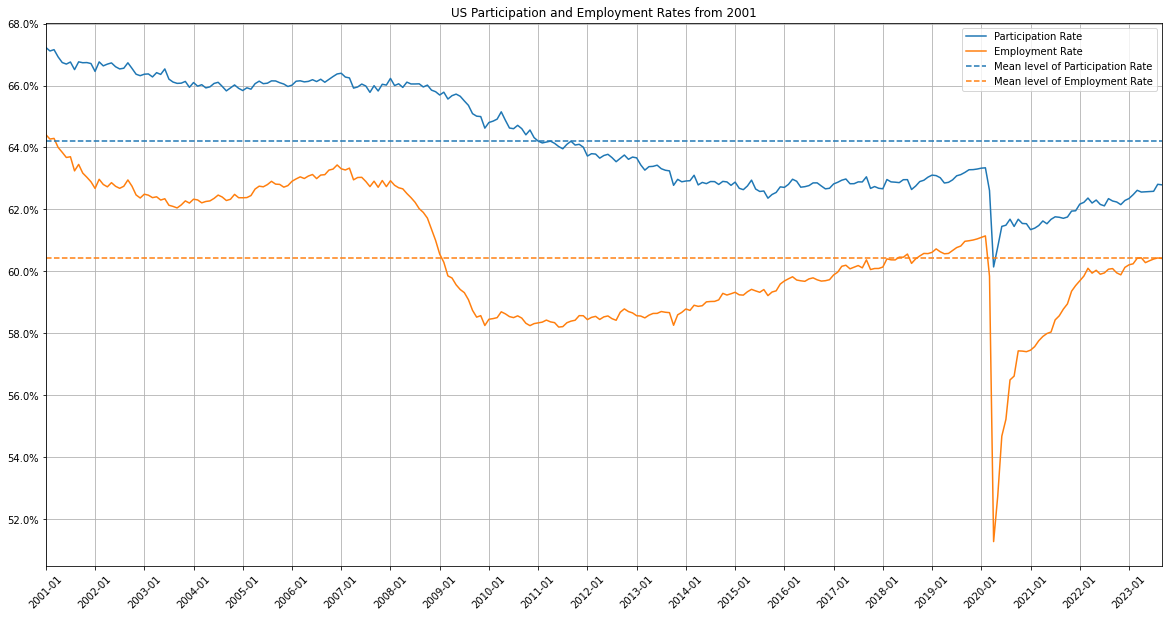

In [7]:
data_short = data.loc['2001':]
ax = data_short.iloc[:,4:6].plot(figsize=(20,10), grid=True,
                                title=UNEMPLOYMENT_RATIOS_SUBSET_1_GRAPH_TITLE + ' from %d' % data_short.index[0].year,
                                xticks=data_short.index[::12], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=data_short.iloc[:,4].mean(), ls='--', c='#1f77b4', label=MEAN_PARTICIPATION_RATE)
ax.axhline(y=data_short.iloc[:,5].mean(), ls='--', c='#ff7f0e', label=MEAN_EMPLOYMENT_POPULATION_RATE)
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, data_short.index[::12])))

In [8]:
SINCE = ' since {:%Y-%m}: '.format(data_short.index[0].date())
print(MEAN_PARTICIPATION_RATE + SINCE + '%.4f%%' % (data_short.iloc[:,4].mean()*100))
print(MEAN_EMPLOYMENT_POPULATION_RATE + SINCE + '%.4f%%' % (data_short.iloc[:,5].mean()*100))

Mean level of Participation Rate since 2001-01: 64.2111%
Mean level of Employment Rate since 2001-01: 60.4438%


##### Current and pre-pandemic levels of Participation and Employment rates

In [9]:
pd.options.display.max_rows = 20
data_short.loc['2020':].iloc[:,[0,4,5,6]]

,Population,Participation Rate,Employment Rate,Unemployment Rate
DATE,,,,
2020-01-01,259502,63.3321%,61.0951%,3.5321%
2020-02-01,259628,63.3437%,61.1448%,3.4714%
2020-03-01,259758,62.6102%,59.8445%,4.4173%
2020-04-01,259896,60.1425%,51.2736%,14.7465%
2020-05-01,260047,60.7840%,52.7320%,13.2469%
...,...,...,...,...
2023-05-01,266618,62.5682%,60.2814%,3.6549%
2023-06-01,266801,62.5751%,60.3424%,3.5681%
2023-07-01,267002,62.5849%,60.3973%,3.4954%


In [10]:
df = data_short.loc['2020':].iloc[:,[0,4,5,6]]
employment_to_population_diff_pct = df.iloc[0, 2] - df.iloc[-1, 2]
participation_diff_pct = df.iloc[0, 1] - df.iloc[-1, 1]
print('{:.2%} fewer work-eligible civilians work now compared to {:%Y-%m-%d}'.format(
      employment_to_population_diff_pct, df.index[0].date()))
print('This is roughly {:d} thousand people using population level of {:%Y-%m-%d}'.format(
    int(df.iloc[0, 0] * employment_to_population_diff_pct), df.index[0].date()))
print('and %d thouand people using the current population level.'
      % int(df.iloc[-1, 0] * employment_to_population_diff_pct))

print('\n{:.2%} fewer work-eligible civilians work or are looking for work now compared to {:%Y-%m-%d}'.format(
      participation_diff_pct, df.index[0].date()))
print('This is roughly {:d} thousand people using population level of {:%Y-%m-%d}'.format(
    int(df.iloc[0, 0] * participation_diff_pct), df.index[0].date()))
print('and %d thouand people using the current population level.' % int(df.iloc[-1, 0] * participation_diff_pct))

0.68% fewer work-eligible civilians work now compared to 2020-01-01
This is roughly 1761 thousand people using population level of 2020-01-01
and 1815 thouand people using the current population level.

0.54% fewer work-eligible civilians work or are looking for work now compared to 2020-01-01
This is roughly 1396 thousand people using population level of 2020-01-01
and 1438 thouand people using the current population level.


**Conclusion**: While the Unemployment Rate has fallen back to the pre-pandemic levels, the participation and employment/population rates, haven't recovered to their pre-Covid highs. We have ≈0.75% fewer work-eligible civilians that work or are looking for work now compared to Jan 2020. This is roughly 1.9 million fewer workers. The labor force has shrunk in relative terms.

#### The Unemployment Rate
This is by far the most widely known measure of the labor market.

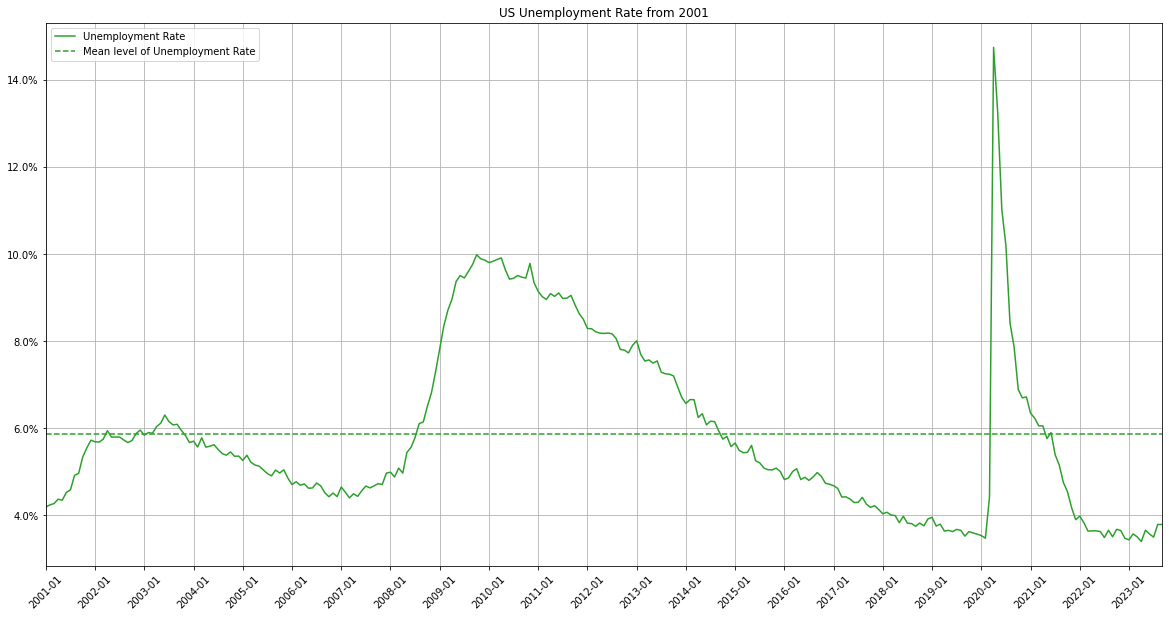

In [11]:
ax = data_short.iloc[:,6:7].plot(figsize=(20,10), grid=True,
                                title=UNEMPLOYMENT_RATIOS_SUBSET_2_1_GRAPH_TITLE + ' from %d' % data_short.index[0].year,
                                xticks=data_short.index[::12], xlabel='', rot=45,
                                color=['#2ca02c', '#d62728', '#9467bd'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=data_short.iloc[:,6].mean(), ls='--', c='#2ca02c', label=MEAN_UNEMPLOYMENT_RATE)
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, data_short.index[::12])))

In [12]:
print(MEAN_UNEMPLOYMENT_RATE + SINCE + '{:.4%}'.format(data_short.iloc[:,6].mean()))

Mean level of Unemployment Rate since 2001-01: 5.8656%


#### Unfilled Vacancies to Population and Job-vacancy (aka Unfilled Vacancies to Labor Force) rates
In this sction I look at ratios to do with unfilled vacancies"
* _The Unfilled Vacancies to Population rate_ shows the ratio of unfilled vacancies to the total population that work or can in theory work.
* _The Job Vacancy Rate_ (aka _The Unfilled Vacancies to Labor Force rate_) is by far the most well known of the two. It shows the ration of unfilled vacancies to the labor force (i.e. the total pool of people who are working or are looking for work. I like this measure more than _Job vacancies per unemployed_, which I describe furthe down in this notebook because in the present labor market an increasing number of vacancies (four-fifths) are filled by job switchers rather than the enemployed.

Both unfilled vacancies to population and unfilled facancies to labor force ratios show that labor demand is still unusually high by historical levels, which makes it likely that the FOMC may continue keeping rates at elevated levels: [the current levels of CPI and Wage Inflation](./M2_PCE_and_CPI.ipynb).

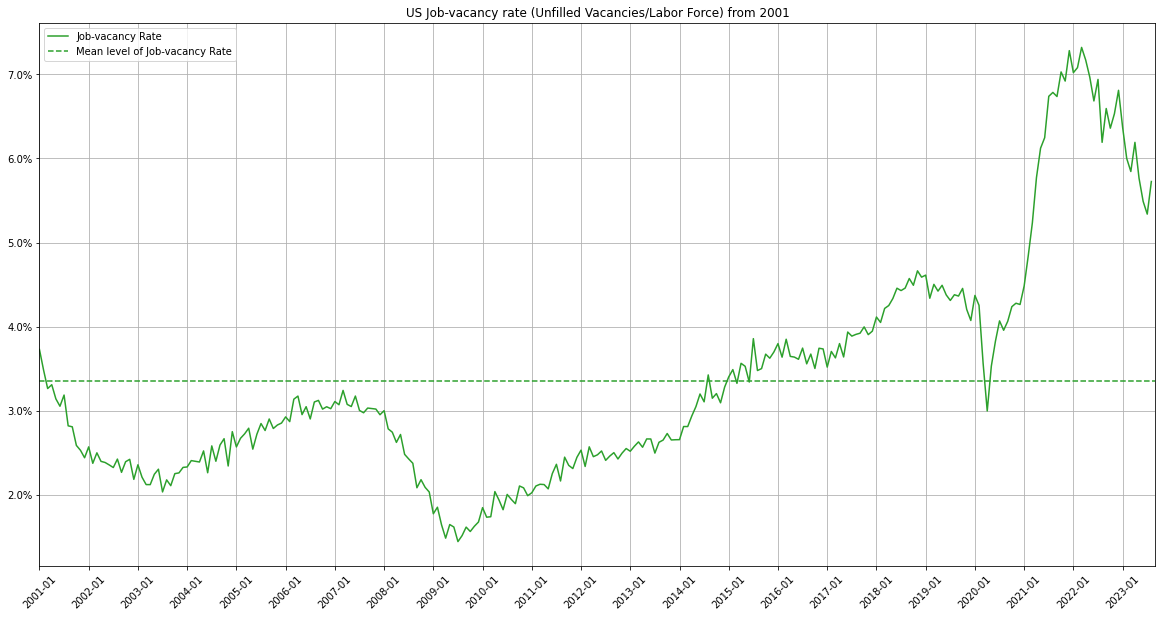

In [13]:
# UNEMPLOYMENT_RATIOS_SUBSET_4_GRAPH_TITLE <-- Unfilled vacancies/Labor force rate
ax = data_short.iloc[:,8:].plot(figsize=(20,10), grid=True,
                                title=UNEMPLOYMENT_RATIOS_SUBSET_4_GRAPH_TITLE + ' from %d' % data_short.index[0].year,
                                xticks=data_short.index[::12], xlabel='', rot=45,
                                color=['#2ca02c', '#d62728', '#9467bd'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
# ax.axhline(y=data_short.iloc[:,6].mean(), ls='--', c='#2ca02c', label=MEAN_UNEMPLOYMENT_RATE)
# ax.axhline(y=data_short.iloc[:,7].mean(), ls='--', c='#d62728', label=MEAN_UNFILLED_VACANCIES_POPULATION_RATE)
ax.axhline(y=data_short.iloc[:,8].mean(), ls='--', c='#2ca02c', label=MEAN_UNFILLED_VACANCIES_LABOR_FORCE_RATE)
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, data_short.index[::12])))

In [14]:
print(MEAN_UNFILLED_VACANCIES_POPULATION_RATE + SINCE + '{:.4%}'.format(data_short.iloc[:,7].mean()))
print(MEAN_UNFILLED_VACANCIES_LABOR_FORCE_RATE + SINCE + '{:.4%}'.format(data_short.iloc[:,8].mean()))

Mean level of Unfilled Vacancies/Population Rate since 2001-01: 2.1375%
Mean level of Job-vacancy Rate since 2001-01: 3.3517%


In [15]:
data_short.loc['2020':].iloc[:,[3,6,7,8]].dropna()

,Unfilled Vacancies,Unemployment Rate,Unfilled Vacancies/Population Rate,Job-vacancy Rate
DATE,,,,
2020-01-01,7184,3.5321%,2.7684%,4.3712%
2020-02-01,6995,3.4714%,2.6942%,4.2534%
2020-03-01,5794,4.4173%,2.2305%,3.5626%
2020-04-01,4686,14.7465%,1.8030%,2.9979%
2020-05-01,5581,13.2469%,2.1462%,3.5308%
...,...,...,...,...
2023-04-01,10320,3.3938%,3.8732%,6.1912%
2023-05-01,9616,3.6549%,3.6067%,5.7644%
2023-06-01,9165,3.5681%,3.4351%,5.4896%


In [16]:
print('There’re {:.2f}mn more unfilled vacancies than in {:%Y-%m}'.format(
    (data_short.loc['2020':].iloc[-2,3]-data_short.loc['2020':].iloc[0,3])/1000.,
    data_short.loc['2020':].index[0]))

There’re 2.43mn more unfilled vacancies than in 2020-01


#### Unfilled Vacancies to Unemployement level (aka Job vacancies per unemployed person)
An additional metric frequently used to measure the tightness of labor market is the ratio of unfilled vacancies to the unemployment level.

I personally prefer to look at the Job-vacancy rate (aka unfilled vacancies to labour force level rate) &mdash; i.e. job vacancies per already working or looking for work, which I've looked at in the previous section. This is because for white-collar jobs it is frequent that employees chanege jobs without going unemployed. Nevertheless, here's analysis unfilled vacancies per unemployed person in the US.

In [17]:
job_vacancies_per_unemployed = (data_short.iloc[:,3]/(data_short.iloc[:,1]-data_short.iloc[:,2]))\
        .rename('Job vacancies per unemployed person')

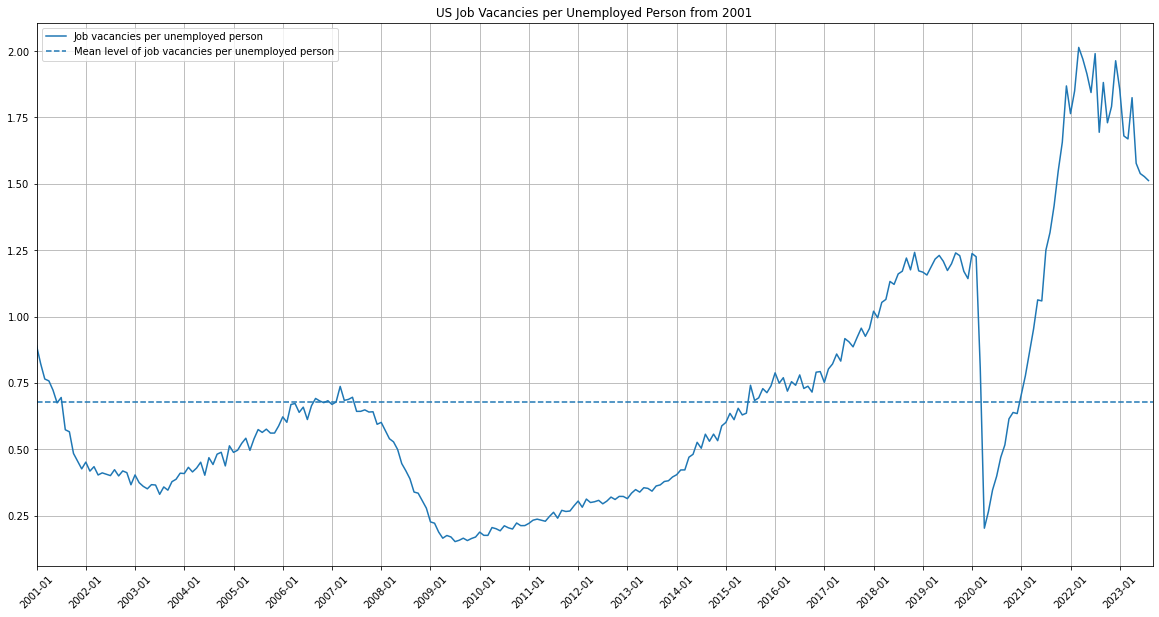

In [18]:
ax = job_vacancies_per_unemployed.plot(figsize=(20,10), grid=True,
                                title=UNEMPLOYMENT_RATIOS_SUBSET_5_GRAPH_TITLE + ' from {:%Y}'.format(job_vacancies_per_unemployed.index[0]),
                                xticks=job_vacancies_per_unemployed.index[::12], xlabel='', rot=45)
ax.axhline(y=job_vacancies_per_unemployed.mean(), ls='--', label=MEAN_VACANCIES_PER_UNEMPLOYED)
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, job_vacancies_per_unemployed.index[::12])))

In [19]:
pd.options.display.float_format = None
job_vacancies_per_unemployed.loc['2020':]

DATE
2020-01-01    1.237554
2020-02-01    1.225258
2020-03-01    0.806514
2020-04-01    0.203297
2020-05-01    0.266536
                ...   
2023-05-01    1.577169
2023-06-01    1.538526
2023-07-01    1.527136
2023-08-01    1.512195
2023-09-01         NaN
Name: Job vacancies per unemployed person, Length: 45, dtype: float64

In [20]:
print('Mean level of job vacancies per unemployed person since {:%Y-%m} is: {:.2f}'.format(
    job_vacancies_per_unemployed.index[0], job_vacancies_per_unemployed.mean()))

Mean level of job vacancies per unemployed person since 2001-01 is: 0.68


#### The Beveridge Curve
[The Beveridge Curve](https://en.wikipedia.org/wiki/Beveridge_curve) compares the unemployment rate to the job-vacancy rate (the number of job vacancies divided by the total labour force) and shows how this changes over time. I've looked at each of these rates individually earlier in this notebook, in this section I plot one against the other. 

The Beveridge curve tends to show an inverse relationship &mdash; unfilled vacancies tend to increase as unemployment rate decreases. The logic being that when few are looking for a job, employers tale longer to fill in their vacancies. Those years where the vacancy rate is higher for the same unemployment rate consitute less efficient a labor market where 1) skills mismatches between employers and job seekers, or 2) vacancies being filled predominantly by job switcheres rather than the jobless, or 3) lower willingness on the part of the unemployed to take a given job might be the reasons. At the moment is is Reason 2 that's most likely the cause of today's "inefficiency" of the US job market where the same low unemployment rate as in 2014-2017 corresponds to a much higher vacancy rate. It is believed that about four-fifth of vacancies is being filled by job switchers nowadays. When vacancies are filled this way they vacancy rate cannot start declining as one job switcher filles one vacancy and automatically causes his past employer to open another.

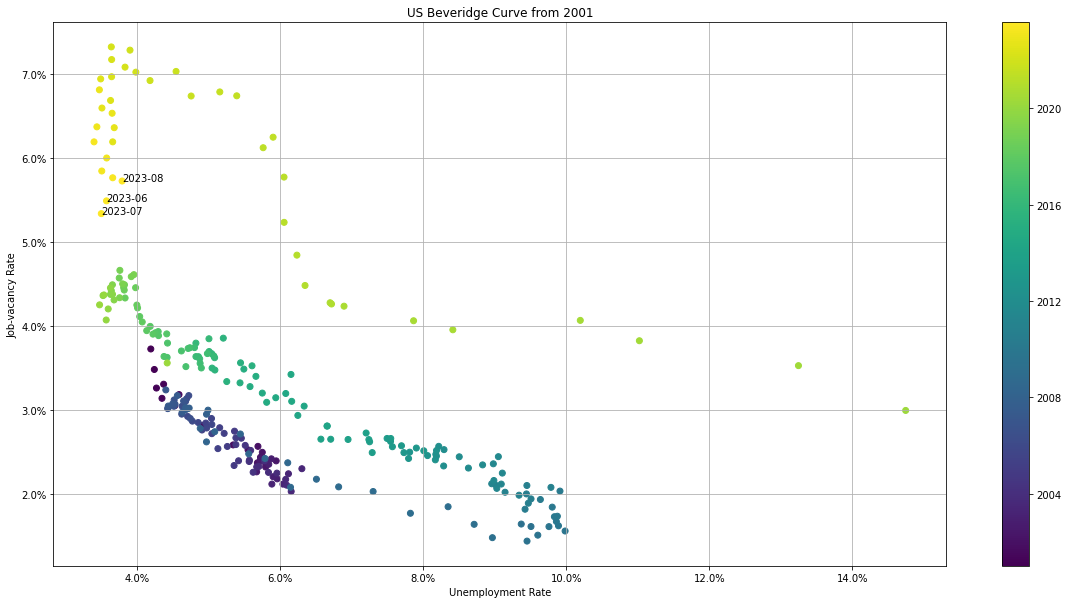

In [25]:
bvg_curve_df = data_short.iloc[:,[6,8]].dropna()
fig, ax = plt.subplots(figsize=(20, 10))
sc = ax.scatter(x=bvg_curve_df.iloc[:,0], y=bvg_curve_df.iloc[:,1], c=mdates.date2num(bvg_curve_df.index))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_xlabel(bvg_curve_df.columns[0])
ax.set_ylabel(bvg_curve_df.columns[1])
ax.set_title('US Beveridge Curve from {:%Y}'.format(bvg_curve_df.index[0]))
# Add labels to the last three months for ease of understanding the current trend
for i in range(-1, -4, -1):
    plt.text(bvg_curve_df.iloc[i,0], bvg_curve_df.iloc[i,1], f'{bvg_curve_df.index[i]:%Y-%m}')
ax.grid(True)
loc = mdates.AutoDateLocator()
_ = fig.colorbar(sc, ticks=loc, format=mdates.AutoDateFormatter(loc))

**Conclusion**: The Unemployment Rate has fallen back to the pre-pandemic levels, i.e. among those who are interested in working the percentage of those who still haven't found a job is about the same. However the number of unfilled vacancies to the Labor force level ratio is still much higher than where it was pre-Covid. There are 2.64 million more unfilled vacancies and 2 million fewer workers compared to Jan 2020, which gives rise to a much higher Unfilled Vacancies to Labor Force Level ratio of 5.89% than before the pandemic (4.37%). When looking at the tightness of the labor market as measured in the number of unfilled job vacancies per unemployed person, the labour market is also mich tighter than before Covid (1.61 vacancies per unemployed now vs 1.24 pre-Covid). 

### Do increases in the Fed Funds Rate correlate with increases in the Participation or Unemployment rates?
It's interesting to see if tightening monetaring policy correlates with increases in the participation or unemployment rates. In the below analysis I look at annual percentage changes. 

Additional series used:
* FEDFUNDS &mdash; Federal Funds Effective Rate (monthly frequency, from 1954)

In [26]:
pct_change_particip_rate = data.iloc[:,4].pct_change(12).loc['1956':]
pct_change_unempl_rate = data.iloc[:,6].pct_change(12).loc['1956':]
pct_change_ffr = web.get_data_fred('FEDFUNDS', start=report_start, end=report_end)
pct_change_ffr = pct_change_ffr.iloc[:, 0].pct_change(12).loc['1956':] 

In [27]:
pct_change_ffr_prtr = pd.concat([pct_change_ffr, pct_change_particip_rate, pct_change_unempl_rate], axis=1).loc['2000':]

# For better visualization
means = pct_change_ffr_prtr.mean()
pct_change_ffr_prtr.iloc[:, 0] /= 100
pct_change_ffr_prtr.iloc[:, 2] /= 10

pct_change_ffr_prtr.rename(
    columns={'FEDFUNDS': 'Fed Funds Annual Percentage Changes / 100', 
             PARTICIPATION_RATE: PARTICIPATION_RATE + ANNUAL_PERCENTAGE_CHANGES,
             UNEMPLOYMENT_RATE: UNEMPLOYMENT_RATE + ANNUAL_PERCENTAGE_CHANGES + ' / 10'},
    inplace=True)

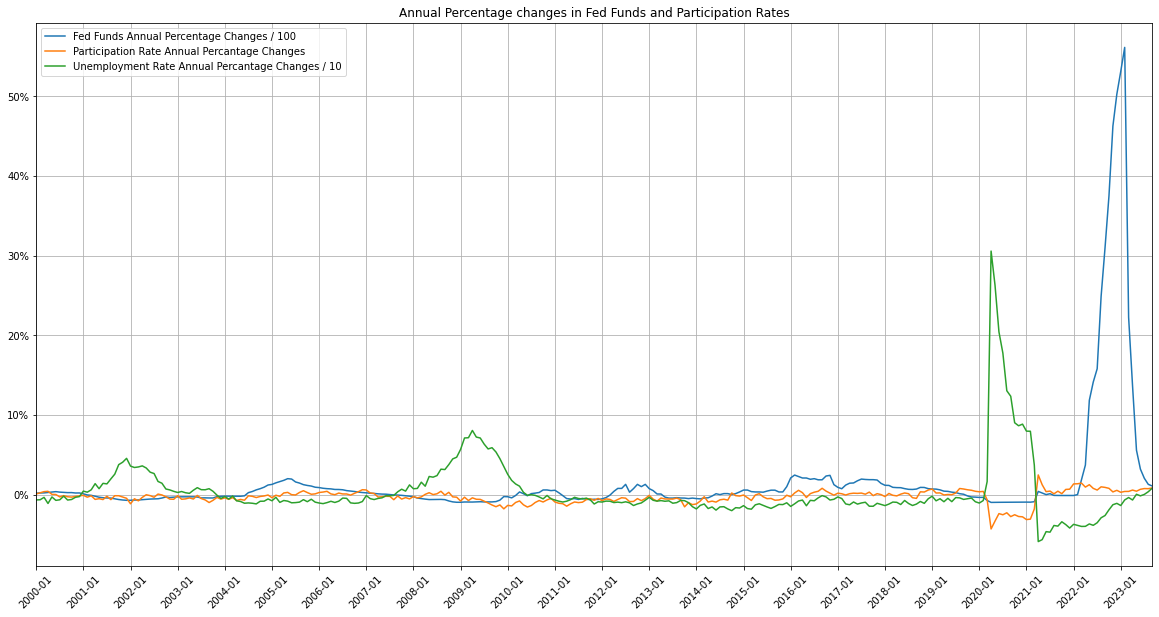

In [28]:
ax = pct_change_ffr_prtr.plot(figsize=(20,10), grid=True,
                              title='Annual Percentage changes in Fed Funds and Participation Rates',
                              xticks=pct_change_ffr_prtr.index[::12], xlabel='', rot=45)#, yticks=np.arange(0, .8, .05))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, pct_change_ffr_prtr.index[::12])))

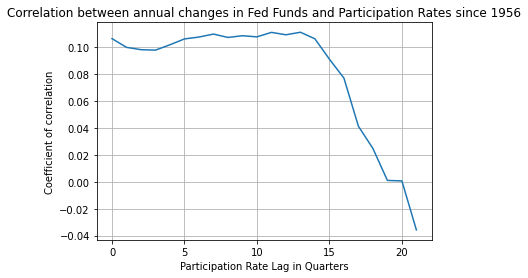

In [29]:
idx = pd.Index(range(22), name='Participation Rate Lag in Quarters')
effect_of_monetary_tightening = pd.Series(idx.map(lambda lag: pct_change_ffr.corr(pct_change_particip_rate.shift(-lag))), index=idx)
_ = effect_of_monetary_tightening.plot(grid=True, title=CORRELATION_FFR_PR_GRAPH_TITLE + ' since 1956',
                                       ylabel='Coefficient of correlation')

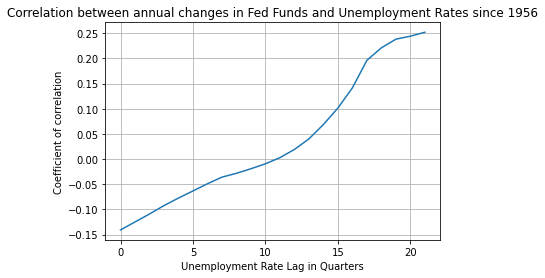

In [30]:
idx2 = pd.Index(range(22), name='Unemployment Rate Lag in Quarters')
effect_of_monetary_tightening = pd.Series(idx.map(lambda lag: pct_change_ffr.corr(pct_change_unempl_rate.shift(-lag))), index=idx2)
_ = effect_of_monetary_tightening.plot(grid=True, title=CORRELATION_FFR_UR_GRAPH_TITLE + ' since 1956',
                                       ylabel='Coefficient of correlation')

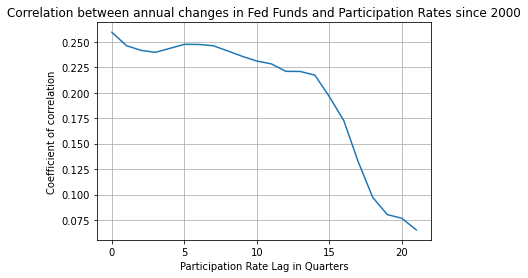

In [31]:
effect_of_monetary_tightening = pd.Series(idx.map(lambda lag: pct_change_ffr.loc['2000':].corr(pct_change_particip_rate.loc['2000':].shift(-lag))), index=idx,)
_ = effect_of_monetary_tightening.plot(grid=True, title=CORRELATION_FFR_PR_GRAPH_TITLE + ' since 2000',
                                       ylabel='Coefficient of correlation')

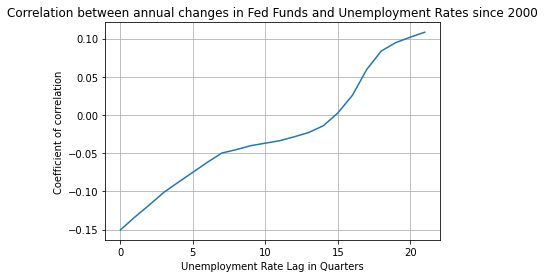

In [32]:
effect_of_monetary_tightening = pd.Series(idx2.map(lambda lag: pct_change_ffr.loc['2000':].corr(pct_change_unempl_rate.loc['2000':].shift(-lag))), index=idx2)
_ = effect_of_monetary_tightening.plot(grid=True, title=CORRELATION_FFR_UR_GRAPH_TITLE + ' since 2000',
                                       ylabel='Coefficient of correlation')

#### Conclusions
* **Fed Funds and Participation Rates**: There's a modest correlation between increases in Fed Funds and Participation rates when we look at the data since 1956. It gets even more pronounced if we look at the correlations between the two in this century. In both cases the correlation gets slightly higher with a lag of 3-4 quarters in the participation rate.
* **Fed Funds and Unemployment Rates**: Surprisingly a negative correlation, unlikely indicative of a causality.